<h1 style="display: flex; align-items: center; justify-content: space-between;">
  Music Information Retrieval
  <img src="https://www.upf.edu/documents/8071534/8177261/MTG_logo-07.png/c5d8ed89-90cf-7fbb-6116-1ab41706aa85?t=1578480743718"
       alt="MTG logo"
       width="180"
       style="vertical-align: middle; margin-left: 20px;" />
</h1>

> This notebook is part of the **Music Information Retrieval (MIR)** course within the  
[**Sound and Music Computing (SMC)**](https://www.upf.edu/web/smc) programme  
at the **Music Technology Group (MTG), Universitat Pompeu Fabra**.

---

### How to Run the Notebook
You can download the notebook and run it locally on your computer.

Alternatively, to access some GPU time for free, open it directly in **Google Colab** using the badge below:

<a target="_blank"
   href="https://colab.research.google.com/github/mrocamora/mir_course/blob/main/notebooks/MIR_course-sound_classification_shallow_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg"
       alt="Open in Colab" />
</a>

---


# Sound Classification - Shallow Pipeline
### About

We will explore sound classification addressing the task of [Mridangam](https://en.wikipedia.org/wiki/Mridangam) stroke type classification. 

**Note**: *this notebook is based on Marius Miron class materials and in a similar notebook available in*
[github.com/MTG/MIRCourse](https://github.com/MTG/MIRCourse/)

## ⚙️ Setup Environment

### Install neccessary dependencies

In [ ]:
# install required packages
!pip install essentia
!pip install mirdata
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install wget # For optionally downloading pre-calculated features

### Import packages

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import mirdata
import essentia.standard as ess
import wget
from IPython.display import Audio

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


## Data Processing

We initialize the [Mridangam stroke dataset](https://mirdata.readthedocs.io/en/latest/source/mirdata.html#module-mirdata.datasets.mridangam_stroke), a collection of 7162 audio examples of individual strokes of the [Mridangam](https://en.wikipedia.org/wiki/Mridangam) in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we want to predict the 10 different stroke classes. 

### Download and Validate

Using mirdata we initialize, download and validate the dataset. For more information on these commands and a general introduction to mirdata there is a good tutorial [here](https://mirdata.readthedocs.io/en/stable/source/tutorial.html).

In [2]:
mridangam = mirdata.initialize("mridangam_stroke")

In [6]:
mridangam.download()

In [7]:
mridangam.validate()

100%|██████████| 6976/6976 [00:00<00:00, 12477.17it/s]


({'tracks': {}}, {'tracks': {}})

### Inspect the Data

Now that the data is downloaded, lets **listen** to and **visualise** some examples.

In [3]:
mridangam_ids = mridangam.track_ids  # Load Mridangam IDs
mridangam_data = mridangam.load_tracks()  # Load Mridangam data

mridangam_data[mridangam_ids[0]]  # Visualize a single track

Audio(mridangam_data[mridangam_ids[0]].audio_path) # Listen to one of the audio files

In [4]:
# Get complete list of different strokes
stroke_names = []
for i in mridangam_ids:
  stroke_names.append(mridangam_data[i].stroke_name)
stroke_names = np.unique(stroke_names)

print(stroke_names)

['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']


In [ ]:
# You can create a dictionary using stroke type as keys
stroke_dict = {item: [] for item in stroke_names}
for i in mridangam_ids:
  stroke_dict[mridangam_data[i].stroke_name].append(mridangam_data[i].audio_path)

# Have a look at the first 10 audio paths for 'cha' stroke
stroke_dict['cha'][:10]

Plot waveforms of random samples of each stroke type...


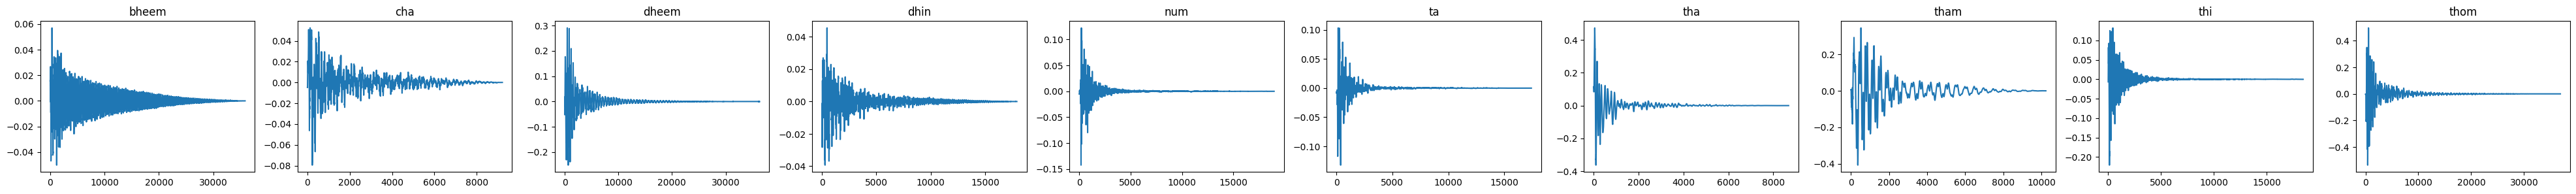

In [7]:
# Raw-data preprocess analysis parameters
_, fs = mridangam_data[mridangam_ids[0]].audio

num_strokes = len(stroke_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_strokes, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, stroke in enumerate(stroke_dict.keys()):
  sample_file = stroke_dict[stroke][file_ind_inlist]
  x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
  
  plt.subplot(1,num_strokes,(i+1))
  plt.plot(x)
  plt.title(stroke)

### Data Preprocessing

- While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 
- We would like to investigate the option of splitting the strokes using a fixed energy threshold (which would help us ignore the silence regions). Let's define a function to perform this operation and visualise some samples to observe the effectiveness of it.
- We want to calculate both the normalised original and segmented data so as to later evaluate **the effect of preprocessing on model performance**.

In [8]:
# Let's define some parameters we will use for fixed energy threshold based segmentation preprocessing approach

# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 # Threshold expressed as ratio with respect to the maximum value

# Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [9]:
# Define function to detect segments based on fixed energy threshold

def find_energy_based_boundaries(filename, params):
  """
  Detects segment boundaries in an audio file based on a fixed energy threshold.

  Params:
    filename (str): Path to the audio file.
    params (dict): Dictionary containing analysis parameters:
      - 'fs': Sample rate
      - 'windowSize': Frame size for analysis
      - 'hopSize': Hop size between frames
      - 'NRG_threshold_ratio': Energy threshold ratio (0-1) for detecting segments

  Returns:
    tuple: (x, NRG, split_decision_func, start_indexes, stop_indexes)
      - x (np.ndarray): Loaded audio signal
      - NRG (np.ndarray): Normalized energy curve
      - split_decision_func (np.ndarray): Binary mask indicating high-energy frames
      - start_indexes (np.ndarray): Start sample indexes of detected segments
      - stop_indexes (np.ndarray): Stop sample indexes of detected segments
  """
  #Unpacking parameters
  fs = params["fs"]
  windowSize = params["windowSize"]
  hopSize = params["hopSize"]
  NRG_threshold_ratio = params["NRG_threshold_ratio"]

  #Loading audio
  x = ess.MonoLoader(filename = filename, sampleRate = fs)()
  NRG = [];
  
  #Main windowing and feature extraction loop
  for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
    NRG.append(ess.Energy()(frame))
  NRG = np.array(NRG)
  NRG = NRG / np.max(NRG)
  
  #Applying energy threshold to decide wave split boundaries
  split_decision_func = np.zeros_like(NRG)
  split_decision_func[NRG > NRG_threshold_ratio] = 1
  
  #Setting segment boundaries
  #Inserting a zero at the beginning since we will decide the transitions using a diff function
  split_decision_func = np.insert(split_decision_func, 0, 0)
  diff_split_decision = np.diff(split_decision_func)
  #Start indexes: transition from 0 to 1
  start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
  #Stop indexes: transition from 1 to 0
  stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
  
  return (x, NRG, split_decision_func, start_indexes, stop_indexes)

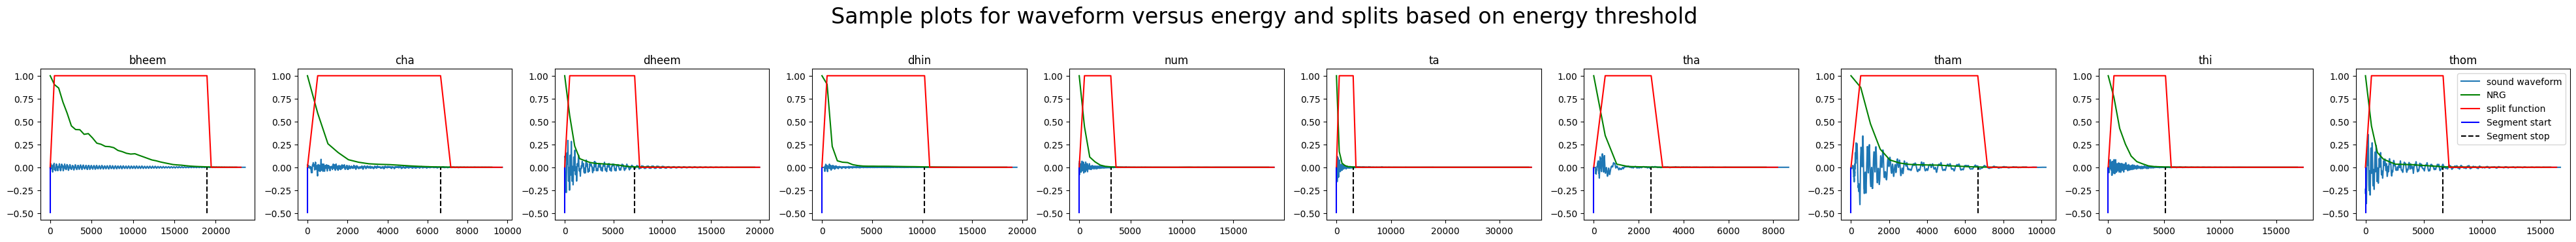

In [10]:
# Let's visualize some sample plots to see how well the fixed energy threshold based segmentation is working

num_strokes = len(stroke_names)

file_indexes = [1]
for file_ind_inlist in file_indexes:
  plt.figure(file_ind_inlist, figsize=(5 * num_strokes, 3))
  plt.suptitle("Sample plots for waveform versus energy and splits based on energy threshold", fontsize=24, y=1.2)
  for i, stroke in enumerate(stroke_dict.keys()):
    sample_file = stroke_dict[stroke][file_ind_inlist]
    (x, NRG, split_decision_func, start_indexes, stop_indexes) = find_energy_based_boundaries(sample_file, params)
    #Plotting functions for checking the split decisions
    plt.subplot(1,num_strokes,(i+1))
    plt.title(stroke)
    plt.plot(x, label = 'sound waveform')
    plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
    plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
    plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
    plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [ ]:
def normalise_and_save_files(stroke_dict, fs, skip_files=None, main_data_dir='sample_data', folder='normalised'):
    os.makedirs(os.path.join(main_data_dir, folder), exist_ok=True)
    save_dir = os.path.join(main_data_dir, folder)
    saved_files = []

    skip_files = skip_files or []

    for files in stroke_dict.values():
        for sample_file in files:
            if sample_file in skip_files:
                continue
            x = ess.MonoLoader(filename=sample_file, sampleRate=fs)()
            x = x / np.max(np.abs(x))
            file_id = sample_file.split('__')[-1].split('.')[0]
            filename = os.path.join(save_dir, f"{file_id}.wav")
            ess.MonoWriter(filename=filename, format='wav', sampleRate=fs)(x)
            saved_files.append(filename)

    print(f"{len(saved_files)} file(s) created")
    return saved_files


# Energy based Segmentation + normalization
def segment_normalize_and_save_files(stroke_dict, fs, params, main_data_dir='sample_data', folder='segments'):
    os.makedirs(os.path.join(main_data_dir, folder), exist_ok=True)
    save_dir = os.path.join(main_data_dir, folder)
    saved_files = []
    skipped_files = []

    for files in stroke_dict.values():
        for sample_file in files:
            x, _, _, starts, stops = find_energy_based_boundaries(sample_file, params)
            segments = [x[s:e] for s, e in zip(starts, stops)]

            has_non_silent = False
            for i, seg in enumerate(segments):
                if np.max(np.abs(seg)) <= 0.05:  # silence check
                    continue
                has_non_silent = True
                seg = seg / np.max(np.abs(seg))  # normalize per segment
                file_id = sample_file.split('__')[-1].split('.')[0]
                filename = os.path.join(save_dir, f"{file_id}_{i}.wav")
                ess.MonoWriter(filename=filename, format='wav', sampleRate=fs)(seg)
                saved_files.append(filename)

            if not has_non_silent:
                skipped_files.append(sample_file)

    print(f"{len(saved_files)} segment file(s) created")
    print(f"{len(skipped_files)} file(s) skipped due to silence")
    return saved_files, skipped_files


Let's now segment and normalise the files, saving these new versions to a separate folder. We also create a version that only normalises the files to use as a baseline, so we can later compare the effectiveness of segmentation-based pre-processing on model performance.

In [ ]:
# ⚠️ Essentia will log out some warning messages but this should not be an issue unless you see an error.
segment_files, skip_files = segment_normalize_and_save_files(stroke_dict, fs, params, main_data_dir='sample_data', folder='segments')

In [43]:
print(len(skip_files), "file(s) skipped due to silence during segmentation.")

123 file(s) skipped due to silence during segmentation.


In [ ]:
# Let's normalise and save the full files too, skipping the ones that were not included during segmentation because of silence
normal_files = normalise_and_save_files(stroke_dict, fs, skip_files, main_data_dir='sample_data', folder='normalised')

In [45]:
print(len(segment_files), "segment file(s) createdm, ", len(normal_files), "normalised file(s) created")

6854 segment file(s) createdm,  6853 normalised file(s) created


Below are some utilities to retrieve lists of processed files from the filesystem if they already exist, as well as a function to delete all files in a given folder.

In [13]:
def get_files_from_folder(folder_path):
  """
  Returns a list of full paths to .wav files in the given folder.

  Params:
    folder_path (str): Path to the folder containing segmented files.

  Returns:
    list: List of file paths to .wav files.
  """
  return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]


# ℹ️ Uncomment and run as needed.

# segments_dir = 'sample_data/segments'
# segment_files = get_files_from_folder(segments_dir)
# print(f"Found {len(segment_files)} segment files.")

# normalised_dir = 'sample_data/normalised'
# normal_files = get_files_from_folder(normalised_dir)
# print(f"Found {len(normal_files)} normalised files.")

In [14]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
  '''Deleting all files in a directory
  '''
  for root, _, files in os.walk(dir_name):
    for file in files:
      file_name = os.path.join(root,file)
      os.remove(file_name);print(file_name, 'removed');


# ℹ️ Uncomment and run as needed.

# delete_files_in_dir(segments_dir)

## Feature Extraction

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

### Choose the features to use

In [52]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(mridangam_data['224030'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


### Calculate the features

We want to calculate the features from the list of audio files we have and then save this data in a CSV file to reuse later.

⚠️ Calculating features on so many files can take quite some time on a typical personal computer or colab session. On a typical laptop it takes 10-15 minutes to calculate. You may **skip this step** and download pre-computed features if you wish.

In [49]:
segmented_data_file = '../data/mridangam_stroke_features_segmented_shared.csv'
normal_data_file = '../data/mridangam_stroke_features_normal_shared.csv'

# ℹ️ Optionally download pre-computed features instead of calculating them, uncomment and run as needed.

# wget.download('https://github.com/mrocamora/mir_course/blob/main/data/mridangam_stroke_features_segmented.csv?raw=true')
# wget.download('https://github.com/mrocamora/mir_course/blob/main/data/mridangam_stroke_features_normal.csv?raw=true')

In [50]:
def extract_features_to_csv(
  file_list, scalar_lowlevel_descriptors, output_csv
):
  """
  Extract features from a list of audio files and write them to a CSV file.

  Params:
    file_list: list of audio file paths
    scalar_lowlevel_descriptors: list of feature names to extract
    output_csv: output CSV file path
  
  Returns:
    None
  """
  import essentia.standard as ess

  file_count = 0
  with open(output_csv, 'w') as writer:
    # adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.', '') + '\n'
    writer.write(line2write)
    for filename in file_list:
      file_count += 1
      if file_count % 20 == 0:  # print name of a file every 20 files
        print(file_count, "files processed, current file: ", filename)

      # Compute and write features for file
      features, features_frames = ess.MusicExtractor(
        lowlevelSilentFrames='drop',
        lowlevelFrameSize=2048,
        lowlevelHopSize=1024,
        lowlevelStats=['mean', 'stdev']
      )(filename)
      selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
       
      label = filename.split('/')[-1].split('.')[0].split('-')[0]
      line2write = str(selected_features)[1:-1] + ',' + label + '\n'
      writer.write(line2write)
  print("A total of", file_count, "files processed")

⚠️ The cells below take a long time to run (~10 to 15 minutes depending on the computing resources you have available)

In [ ]:
if not os.path.exists(segmented_data_file):
    extract_features_to_csv(segment_files, scalar_lowlevel_descriptors, segmented_data_file)
else:
    print(f"{segmented_data_file} already exists, skipping feature extraction.")

In [ ]:
if not os.path.exists(normal_data_file):
    extract_features_to_csv(normal_files, scalar_lowlevel_descriptors, normal_data_file)
else:
    print(f"{normal_data_file} already exists, skipping")

## Prepare Train, Test and Validation Data

Now that we have extracted the features, we need to address any class imbalance and split the data into training, validation, and test sets to properly evaluate.

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

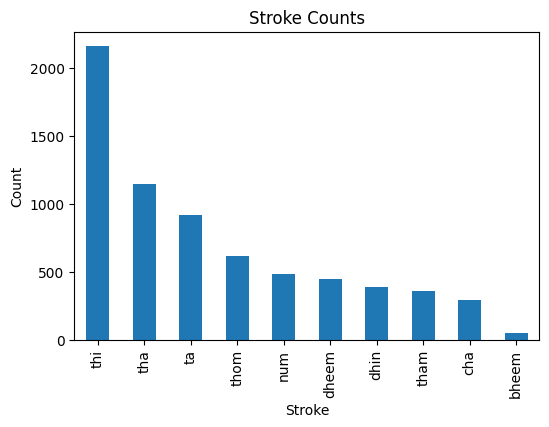

In [20]:
# Load features data
data_test = pd.read_csv(segmented_data_file)

# Count values
counts = data_test.stroke.value_counts()

# Plot bar chart of stroke counts
counts.plot(kind='bar', figsize=(6, 4))
plt.title("Stroke Counts")
plt.xlabel("Stroke")
plt.ylabel("Count")
plt.show()

We see that there is a broad range of frequencies of each stroke class. We will downsample to the number of instances of the __cha__ stroke, leaving the instances of the __bheem__ stroke un-altered.


In [21]:
def downsample_strokes_rebalance(data, exception_classes=None, rebalance_class='cha', random_state=42):
  """
  Rebalances stroke classes by downsampling so that all classes 
  (except the exception_classes) have the same number of samples 
  as rebalance_class.
  
  Params:
    data: Input dataframe with a 'stroke' column.
    exception_classes (list[str] or None): Classes not to be downsampled.
    rebalance_class: Class used to determine the target sample size.
    random_state: Random seed for reproducibility.
  
  Returns:
    pd.DataFrame: Balanced dataframe.
  """
  if exception_classes is None:
    exception_classes = []
  elif isinstance(exception_classes, str):
    # Allow a single class to be passed as a string
    exception_classes = [exception_classes]

  # Target sample size
  target_size = data.stroke.value_counts()[rebalance_class]

  sampled_data = []

  # Downsample all classes except exceptions
  for stroke in data.stroke.unique():
    if stroke in exception_classes:
      sampled_data.append(data[data.stroke == stroke])  # keep full
    else:
      sampled_data.append(
        data[data.stroke == stroke].sample(n=target_size, random_state=random_state)
      )

  # Merge all
  return pd.concat(sampled_data, ignore_index=True)

Data preperation pipeline for training, validation and testing splits.

In [ ]:
def prepare_data_for_training(data_file, test_size=0.2, val_size=0.1, random_state=42):
    """
    Prepares data for training by reading from CSV, balancing classes,
    normalizing features, encoding labels, and splitting into train, val, and test sets.
    Params:
        data_file (str): Path to the CSV file containing features and labels.
        test_size: Proportion of the dataset to include in the test split.
        val_size: Proportion of the dataset to include in the validation split.
        random_state: Random seed for reproducibility.
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, label_encoder
    """
    # Read CSV
    data = pd.read_csv(data_file)

    # Balance the dataset
    data_balanced = downsample_strokes_rebalance(
        data, 
        exception_classes=['bheem'], 
        rebalance_class='cha',
        random_state=random_state
    )

    print("Stroke counts after balancing:\n", data_balanced.stroke.value_counts())

    # Separate features (first 84 cols) and labels
    X = data_balanced.iloc[:, :-1].values   # all columns except last
    y = data_balanced.iloc[:, -1].values    # last column (stroke)

    # Normalize features
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode labels (string to numeric)
    label_encoder = preprocessing.LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # First split: train vs temp (test+val)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y_encoded, test_size=(test_size + val_size), random_state=random_state, stratify=y_encoded
    )
    # Compute relative val size in temp
    val_ratio = val_size / (test_size + val_size)
    # Second split: temp to val and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio), random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [55]:
# Get our data ready for training!
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_data_for_training(segmented_data_file)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape, "Val shape:", X_val.shape)
print("Classes:", label_encoder.classes_)

Stroke counts after balancing:
 stroke
cha      294
dheem    294
tha      294
dhin     294
num      294
ta       294
thi      294
tham     294
thom     294
bheem     46
Name: count, dtype: int64

Train shape: (1884, 84) Test shape: (539, 84) Val shape: (269, 84)
Classes: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']


In [56]:
# Get data for the normalised non-segmented files
X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm, label_encoder_norm = prepare_data_for_training(normal_data_file)

Stroke counts after balancing:
 stroke
cha      294
dheem    294
tha      294
dhin     294
num      294
ta       294
thi      294
tham     294
thom     294
bheem     46
Name: count, dtype: int64


## Supervised Learning Approaches

We will compare [Support vector machines (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and a simple [MLP classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) neural network implemented using [sklearn](https://scikit-learn.org/stable/index.html).

In [57]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

### On segmented data

In [58]:
# Intialise and train SVM using sklearn
svm = SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()), random_state=42)
svm.fit(X_train, y_train)

# Store validation and full test results
svm_val_acc_segmented = svm.score(X_val, y_val)
svm_test_report_segmented = classification_report(
    y_test, svm.predict(X_test), target_names=label_encoder.classes_, output_dict=True
)

In [ ]:
# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, random_state=42)
mlp.fit(X_train, y_train)

# Store validation and full test results
mlp_val_acc_segmented = mlp.score(X_val, y_val)
mlp_test_report_segmented = classification_report(
    y_test, mlp.predict(X_test), target_names=label_encoder.classes_, output_dict=True
)

#### On baseline



In [ ]:
# Intialise and train SVM using sklearn
svm_baseline = SVC(gamma = 1 / (X_train_norm.shape[-1] * X_train_norm.var()), random_state=42)
svm_baseline.fit(X_train_norm, y_train_norm)

# Store validation and full test results
svm_val_acc_normal = svm_baseline.score(X_val_norm, y_val_norm)
svm_test_report_normal = classification_report(
    y_test_norm, svm_baseline.predict(X_test_norm), target_names=label_encoder_norm.classes_, output_dict=True
)

In [ ]:
# Train MLP
mlp_baseline = MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, random_state=42)
mlp_baseline.fit(X_train_norm, y_train_norm)

# Store validation and full test results
mlp_val_acc_normal = mlp_baseline.score(X_val_norm, y_val_norm)
mlp_test_report_normal = classification_report(
    y_test_norm, mlp_baseline.predict(X_test_norm), target_names=label_encoder_norm.classes_, output_dict=True
)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


## 📊 Results

### Compare segmented data against baseline


In [63]:
# Helper function to create a results DataFrame for a model
def create_results_df(model_label, val_accuracy, test_report_dict):
    test_accuracy = test_report_dict['accuracy']
    return pd.DataFrame({
        'Model': [model_label],
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy]
    })

# Create individual DataFrames for each result
df_mlp_normal = create_results_df('MLP Normal', mlp_val_acc_normal, mlp_test_report_normal)
df_mlp_segmented = create_results_df('MLP Segmented', mlp_val_acc_segmented, mlp_test_report_segmented)
df_svm_normal = create_results_df('SVM Normal', svm_val_acc_normal, svm_test_report_normal)
df_svm_segmented = create_results_df('SVM Segmented', svm_val_acc_segmented, svm_test_report_segmented)

# Combine all results into a single table
acc_df = pd.concat([df_mlp_normal, df_mlp_segmented, df_svm_normal, df_svm_segmented], ignore_index=True)

# Format accuracy columns to show as percentages for better readability
acc_df['Validation Accuracy'] = acc_df['Validation Accuracy'].map('{:.2%}'.format)
acc_df['Test Accuracy'] = acc_df['Test Accuracy'].map('{:.2%}'.format)

display(acc_df)

,Model,Validation Accuracy,Test Accuracy
0,MLP Normal,94.80%,93.88%
1,MLP Segmented,92.19%,94.06%
2,SVM Normal,87.73%,85.34%
3,SVM Segmented,88.85%,91.84%


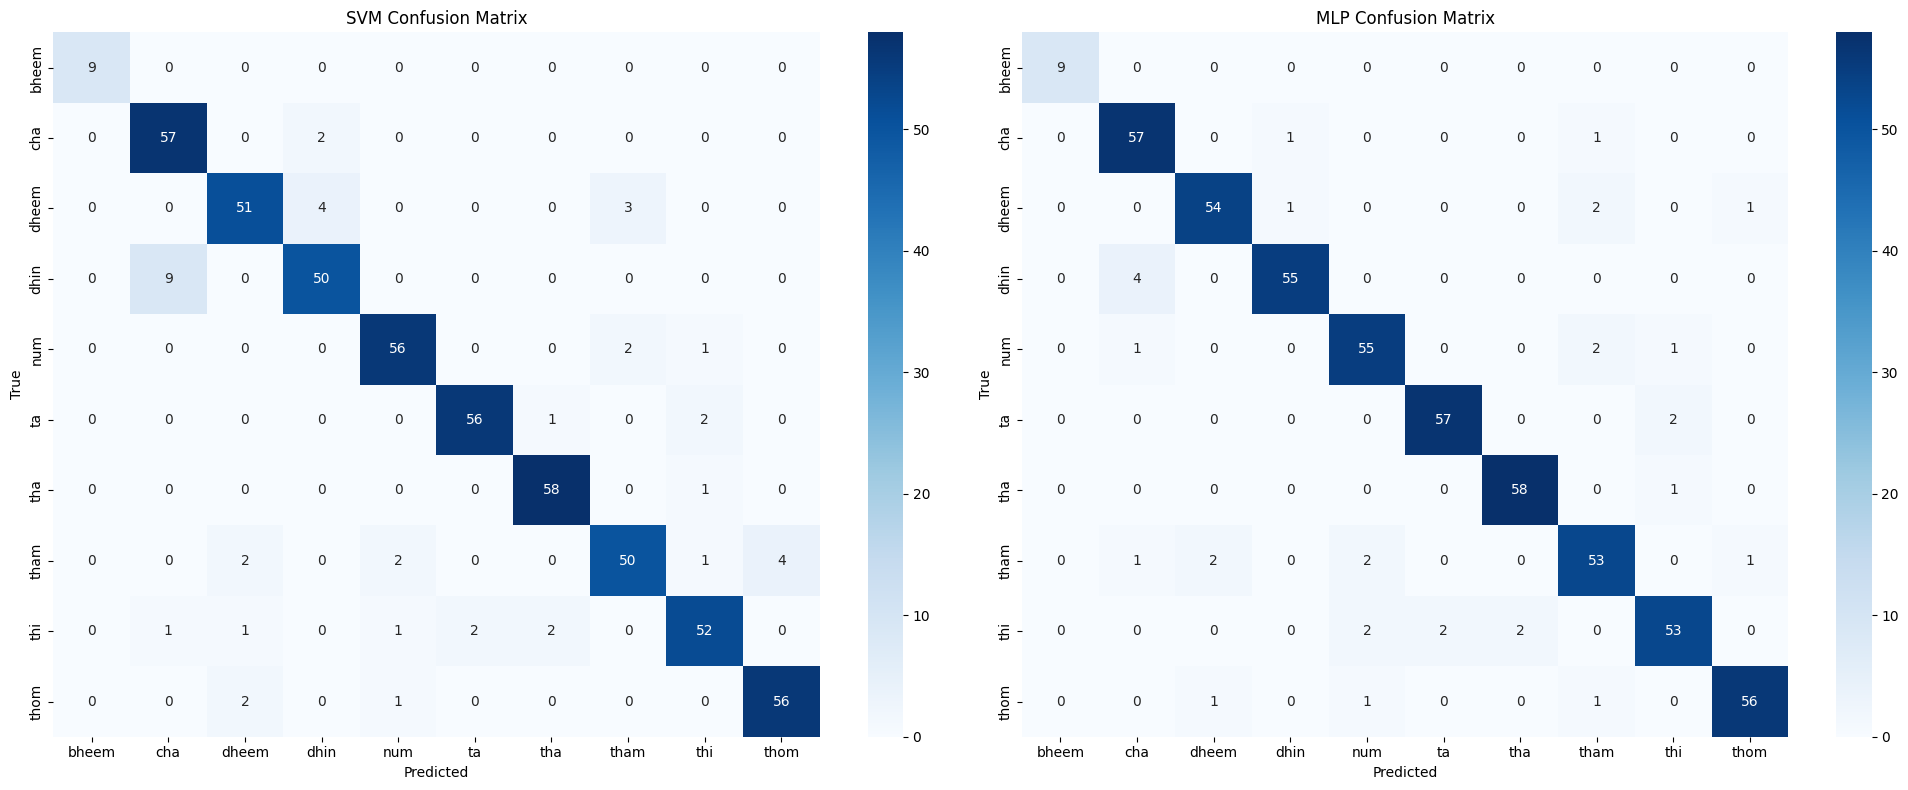

In [33]:
# Get predictions
svm_pred = svm.predict(X_test)
mlp_pred = mlp.predict(X_test)

# Create confusion matrices
svm_cm = confusion_matrix(y_test, svm_pred)
mlp_cm = confusion_matrix(y_test, mlp_pred)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot SVM confusion matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
      yticklabels=label_encoder.classes_, ax=ax1)
ax1.set_title('SVM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot MLP confusion matrix
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
      yticklabels=label_encoder.classes_, ax=ax2)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

## 💭 Questions

---

1. Why does segmentation improve the performance of the SVM more than that of the MLP against the baseline?
2. Can you handle the class inbalance in a better way?
    - Consider using data augmentation techniques.
3. Can you do some error analysis?
    - Look at confusions that are common between the two models
    - Look at the results above, listen to and inspect inidvidual error cases try to explain why they were mis-classified.
    - Can any patterns be identified?

<!-- 3. Is there an upper bound on the performance for the current models used? -->


## 💡 Possible Extensions
---

1. Improve the feature selection
    - Handpick 5 essentia features that you think will help the models effectively discriminate between classes in this task. Why did you choose these?
    - Use statistical methods such as [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
    - Can a balance be struck between number of features and performance?
2. Try alternative models
    - RandomForest
    - Unsupervised approaches (KNNs etc)
3. Optimise hyperparameters
    - How much does this improve performance?
    - You might experiment with tools such as [Optuna](https://optuna.org/)
